<a href="https://colab.research.google.com/github/Sirath07/projects-emotion_detector.ipynb/blob/main/emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle

In [ ]:
!mkdir -p /content/emotion-recognition-intermediate/data
%cd /content/emotion-recognition-intermediate

/content/emotion-recognition-intermediate


In [ ]:
%%bash
cat > dataset.py <<'PY'
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from torchvision import transforms

class FERDataset(Dataset):
    def __init__(self, csv_file, usage='Training', transform=None):
        df = pd.read_csv(csv_file)
        df = df[df['Usage'] == usage]
        self.labels = df['emotion'].values
        self.images = df['pixels'].values

        if transform is None:
            if usage == 'Training':
                self.transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(10),
                    transforms.ToTensor(),
                    transforms.Normalize([0.5], [0.5])
                ])
            else:
                self.transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.ToTensor(),
                    transforms.Normalize([0.5], [0.5])
                ])
        else:
            self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = np.array(self.images[idx].split(), dtype='uint8').reshape(48,48)
        img = np.stack([img, img, img], axis=-1)  # convert grayscale to 3-channel
        img = self.transform(img)
        label = int(self.labels[idx])
        return img, torch.tensor(label, dtype=torch.long)
PY

cat > model.py <<'PY'
import torch.nn as nn
from torchvision import models

class EmotionResNet(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        # ResNet expects 3-channel input — we used 3-channel stacked grayscale
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)
PY

cat > train.py <<'PY'
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from dataset import FERDataset
from model import EmotionResNet
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

train_dataset = FERDataset("data/fer2013.csv", usage='Training')
val_dataset   = FERDataset("data/fer2013.csv", usage='PublicTest')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

model = EmotionResNet(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

best_val_acc = 0.0
save_path = "best_model.pth"
epochs = 8

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total

    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print(f"Saved best model (val acc {best_val_acc:.4f}) to {save_path}")
PY

cat > evaluate.py <<'PY'
import torch
from dataset import FERDataset
from model import EmotionResNet
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
emotions = ["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]

model = EmotionResNet(num_classes=7)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()

test_dataset = FERDataset("data/fer2013.csv", usage='PublicTest')
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
print("Test Accuracy:", acc)
print(classification_report(all_labels, all_preds, target_names=emotions))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotions, yticklabels=emotions)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
PY

cat > predict.py <<'PY'
import torch
import cv2
from model import EmotionResNet
from torchvision import transforms
from PIL import Image
import numpy as np

emotions = ["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]
device = "cuda" if torch.cuda.is_available() else "cpu"

model = EmotionResNet(num_classes=7)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

def predict_image(path):
    img = Image.open(path).convert('L')  # grayscale
    img = np.array(img)
    img = np.stack([img, img, img], axis=-1)
    img = Image.fromarray(img)
    t = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(t)
        _, pred = torch.max(out, 1)
    return emotions[pred.item()]

if __name__ == "__main__":
    print(predict_image("test.jpg"))
PY

cat > app.py <<'PY'
import streamlit as st
from predict import predict_image
from PIL import Image

st.title("Face Emotion Recognition Demo")
uploaded = st.file_uploader("Upload an image", type=["jpg","png","jpeg"])
if uploaded:
    img = Image.open(uploaded)
    st.image(img, caption="Uploaded Image", use_column_width=True)
    st.write("Predicting...")
    result = predict_image(uploaded)
    st.header(f"Predicted Emotion: {result}")
PY

cat > README.md <<'MD'
# Advanced Face Emotion Recognition (Intermediate)

Follow the instructions in the notebook or run scripts:
1. Put fer2013.csv in data/
2. Train: python train.py
3. Evaluate: python evaluate.py
4. Predict a single image: python predict.py
5. Run demo: streamlit run app.py
MD

cat > requirements.txt <<'TXT'
torch
torchvision
opencv-python
pandas
numpy
matplotlib
seaborn
streamlit
pillow
scikit-learn
TXT

In [ ]:
import os

print("Files in data/:")
print(os.listdir("/content/emotion-recognition-intermediate/data/"))


Files in data/:
[]


In [ ]:
import zipfile
import os

zip_path = "/content/emotion-recognition-intermediate/data/project.zip"
extract_path = "/content/emotion-recognition-intermediate/data/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted files:")
print(os.listdir(extract_path))

Extracted files:
['project.zip', 'fer2013.csv']


Rows: 35887


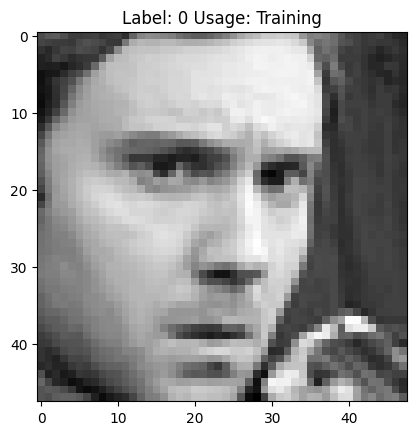

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
df = pd.read_csv("data/fer2013.csv")
print("Rows:", len(df))
row = df.iloc[0]
pixels = np.array(row['pixels'].split(), dtype='float32').reshape(48,48)/255.0
plt.imshow(pixels, cmap='gray'); plt.title(f"Label: {row['emotion']} Usage: {row['Usage']}"); plt.show()

In [ ]:
!python train.py

Device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100% 44.7M/44.7M [00:00<00:00, 120MB/s]
Epoch 1/8 - Loss: 1.4937 - Val Acc: 0.5247
Saved best model (val acc 0.5247) to best_model.pth
Epoch 2/8 - Loss: 1.2064 - Val Acc: 0.5723
Saved best model (val acc 0.5723) to best_model.pth
Epoch 3/8 - Loss: 1.0905 - Val Acc: 0.5982
Saved best model (val acc 0.5982) to best_model.pth
Epoch 4/8 - Loss: 1.0091 - Val Acc: 0.6030
Saved best model (val acc 0.6030) to best_model.pth
Epoch 5/8 - Loss: 0.9445 - Val Acc: 0.6069
Saved best model (val acc 0.6069) to best_model.pth
Epoch 6/8 - Loss: 0.8695 - Val Acc: 0.6071
Saved best model (val acc 0.6071) to best_model.pth
Epoch 7/8 - Loss: 0.8081 - Val Acc: 0.6172
Saved best model (val acc 0.6172) to best_model.pth
Epoch 8/8 - Loss: 0.7416 - Val Acc: 0.6213
Saved best model (val acc 0.6213) to best_model.pth


In [ ]:
!python evaluate.py

Test Accuracy: 0.6213429924770131
              precision    recall  f1-score   support

       Angry       0.55      0.51      0.53       467
     Disgust       0.61      0.45      0.52        56
        Fear       0.51      0.39      0.44       496
       Happy       0.83      0.80      0.81       895
         Sad       0.51      0.51      0.51       653
    Surprise       0.69      0.82      0.75       415
     Neutral       0.53      0.63      0.57       607

    accuracy                           0.62      3589
   macro avg       0.60      0.59      0.59      3589
weighted avg       0.62      0.62      0.62      3589

Figure(800x600)


In [ ]:
# Run in Colab code cell
!nvidia-smi || echo "nvidia-smi not found — GPU not active"


Sun Dec  7 16:47:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Run in Colab
import os
print("Working dir:", os.getcwd())
print("Files in project data/:", os.listdir("data") if os.path.isdir("data") else "data/ not found")
print("Files at root:", os.listdir(".")[:50])


Working dir: /content/emotion-recognition-intermediate
Files in project data/: ['project.zip', 'fer2013.csv']
Files at root: ['best_model.pth', 'train.py', '__pycache__', 'evaluate.py', 'predict.py', 'README.md', 'dataset.py', 'app.py', 'data', 'model.py', 'requirements.txt']


In [ ]:
from google.colab import files
files.download("best_model.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>